# 画像認識1: Cascade Classifierによる顔画像検出

顔や文字の領域検出によく使われる手法です。  

あらかじめ下の図のように白と黒からなる非常に単純な模様（パターン）を沢山用意しておきます。

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/3rd_and_4th_kind_of_Haar_Feature.jpg" width="200">

いま、顔の領域を検出したいとします。   
訓練データとして顔の画像をたくさん用意し、その顔領域に対して、上のような単純なパターンに似ているかどうかを調べていきます。   
例えば下のパターンは顔の眉間部分に似ていそうです。

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8a/Haar_Feature_that_looks_similar_to_the_bridge_of_the_nose_is_applied_onto_the_face.jpg" width="480">

また下のパターンは顔の両目とその下の領域に似ていそうです。

<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/Haar_Feature_that_looks_similar_to_the_eye_region_which_is_darker_than_the_upper_cheeks_is_applied_onto_a_face.jpg" width="480">

このようにして、検出対象が、位置やサイズを合わせればそれぞれのパターンに似ていそうかを調べて行きます。   
これが学習段階です。

次に、入力画像が与えられた時、顔領域を検出する段階について説明します。   
いま、学習段階で顔に似ていると判定されたパターンが、入力画像のある領域に似ていたとします。   
すると、検出器は、「そこは顔かもしれない」と推定します。   
しかし一つのパターンに当てはまっただけだとそのような領域は山ほどあるので、他のパターンも試してみます。  
そうして、学習段階で顔に似ていると判定されたパターンの多くが当てはまる領域を見つけたら、「そこは顔だ！」と判定するわけです。   

画像領域の大きさは、その画像の画素サイズや、その画像内の顔が占める割合によって大きく変わります。   
ですのでこの手法では、入力画像を徐々に縮小しながら、パターンが当てはまるかどうかを端から端までスキャンしていくわけです。   
もしその領域が顔ならば、顔の大きさが多少違っても顔だと検出できそうですね。   
ですので、画像を縮小しながらパターンをスキャンしていくと、顔周辺は何度も顔領域と検出されることになります。   
こうして、何度も顔と検出されたところを、最終的な結果として出力することで、精度を高める工夫をしています。

以下の二つのパラメータをいろいろと変えてみましょう。
- scaleFactor: 画像を徐々に縮小していくとき、どれくらいの幅で縮小していくか？
- minNeighbors：そこが他にいくつ顔だと検出したら顔と判定するか？

参照）画像は[Wikipedia: Viola–Jones object detection framework](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework)より   
参照）下の演習で用いている学習済みモデルは、[github:opencv_contrib](https://github.com/opencv/opencv_contrib)のものを使っています。ライセンスは`opencv_data/LICENSE`をご参照ください。

## 1. 準備：モデルとサンプル画像のダウンロード

In [1]:
# この作業は1回のみで結構です！1回だけ、以下のコードの最初と最後にある「'''」を消してから実行してください。


import urllib.request
import os
if not os.path.exists('opencv_data'):
    os.mkdir('opencv_data')
if not os.path.exists('img'):
    os.mkdir('img')

# ダウンロード元
link = ['https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml',
       'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml',
       'https://upload.wikimedia.org/wikipedia/ja/2/27/Kasahara_Saitama_Kasahara_Jinjo_Elementary_School_1920_1.jpg',
       'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/TTT_2019_Group_Photograph.jpg/1280px-TTT_2019_Group_Photograph.jpg',
       'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Super_Tuesday_%286814264898%29.jpg/1024px-Super_Tuesday_%286814264898%29.jpg']
# ダウンロード先
save = ['opencv_data/haarcascade_frontalface_alt.xml',
       'opencv_data/haarcascade_eye.xml',
       'img/Kasahara_Saitama_Kasahara_Jinjo_Elementary_School_1920_1.jpg',
       'img/1280px-TTT_2019_Group_Photograph.jpg',
       'img/1024px-Super_Tuesday_(6814264898).jpg']

# ダウンロードの実行
for i in range(len(link)):
    urllib.request.urlretrieve(link[i], save[i])


## 2. 顔検出の実行

True

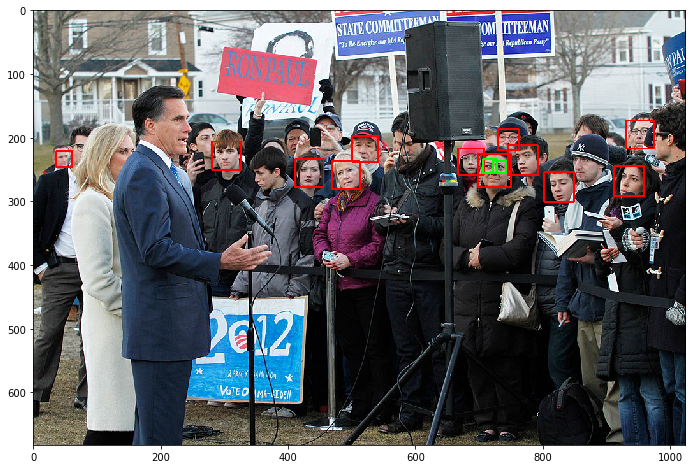

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

# この学習済みモデルは
face_cascade_path = 'opencv_data/haarcascade_frontalface_alt.xml'
eye_cascade_path = 'opencv_data/haarcascade_eye.xml'

face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#imgfile = 'img/Kasahara_Saitama_Kasahara_Jinjo_Elementary_School_1920_1.jpg' # ref. https://ja.wikipedia.org/wiki/%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB:Kasahara_Saitama_Kasahara_Jinjo_Elementary_School_1920_1.jpg public domain
#imgfile = 'img/1280px-TTT_2019_Group_Photograph.jpg' # ref. https://commons.wikimedia.org/wiki/File:TTT_2019_Group_Photograph.jpg CC BY-SA 4.0
imgfile = 'img/1024px-Super_Tuesday_(6814264898).jpg' # ref. https://commons.wikimedia.org/wiki/File:Super_Tuesday_(6814264898).jpg CC BY 2.0

img = cv2.imread(imgfile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(img_gray, 
                                      # 画像サイズを縮小させながらマッチングする際、
                                      # 毎回どれくらい縮小させるかを指定するパラメータ
                                      # この値が1に近いほど少しずつ縮小させながら何度も検出することになるため
                                      # 再現率は上がるけど適合率は下がる。また計算時間が増える
                                      scaleFactor=1.05, 
                                      # もしその領域が確かにfaceであるならば、その領域が何度も検出されるはずです
                                      # このパラメータは、その領域が他にいくつ以上faceとして検出されていれば、
                                      # そこを正解とみなすかを指定します。
                                      # ちなみにその領域が何回くらい検出されているかを確認したいなら
                                      # minNeighborsを0にしてください。こうするとすべての候補が描画されます。
                                      # minNeighborsを1にするということは、領域候補が近傍に2つ以上あるという条件になります
                                      minNeighbors=3)


for x, y, w, h in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    face = img[y: y + h, x: x + w]
    face_gray = img_gray[y: y + h, x: x + w]
    # 顔と検出された領域のそれぞれについて、目の領域を検出する
    eyes = eye_cascade.detectMultiScale(face_gray, scaleFactor=1.05, minNeighbors=1)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(face, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(img)
cv2.imwrite('img/FaceAndEyeDetection.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# おまけ：カメラによるリアルタイム顔画像検出

<font color="red">Colaboratoryの方は実行できません！！！</font>

カメラが内蔵されているノートPCや、あるいはUSBカメラが接続しているPCをお持ちでしたら、カメラで撮影した動画に対してリアルタイムで顔画像検出を試してみてください。   

Anaconda NavigatorからTerminalを起動して、このファイルがおかれているディレクトリに`cd`コマンドで移動し、以下のコマンドを実行します。

`python FaceDetectionWithCamera.py`


新しいウィンドウが立ち上がり、そこで顔画像を認識している様子が見られるはずです。   
撮影画像における顔画像の最小サイズがわかっているならば、そのパラメータを設定することで高速化することができます。
